In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [13]:
def create_pseudo_sigmoid_curve(
    total_points=1000,
    plateau_size=150,
    infection_point=0.5,
    noise_level=0.02,
    steepness=10
):
    """
    Create a pseudo-sigmoidal curve between 0 and 1 with specified plateaus and noise.

    Parameters:
    - total_points (int): Total number of data points.
    - plateau_size (int): Number of points in the starting and ending plateaus.
    - infection_point (float): Inflection point of the sigmoid within the middle segment (0 to 1).
    - noise_level (float): Standard deviation of Gaussian noise to add.
    - steepness (float): Steepness parameter for the sigmoid function.

    Returns:
    - y_noisy (numpy.ndarray): Generated curve with noise.
    """
    # Validate parameters
    if plateau_size * 2 >= total_points:
        raise ValueError("Plateau size is too large for the total number of points.")
    if not (0 <= infection_point <= 1):
        raise ValueError("Infection point must be between 0 and 1.")

    # Number of points in the sigmoid segment
    sigmoid_size = total_points - 2 * plateau_size

    # Generate x values for the sigmoid
    x = np.linspace(0, 1, sigmoid_size)

    # Adjust x to place the inflection point at the desired infection_point
    x_shifted = x - infection_point

    # Compute the sigmoid
    sigmoid = 1 / (1 + np.exp(-steepness * x_shifted))

    # Initialize the full y array
    y = np.zeros(total_points)

    # Assign plateau at the beginning
    y[:plateau_size] = 0

    # Assign sigmoid in the middle
    y[plateau_size:total_points - plateau_size] = sigmoid

    # Assign plateau at the end
    y[total_points - plateau_size:] = 1

    # Add Gaussian noise
    noise = np.random.normal(0, noise_level, total_points)
    y_noisy = y + noise

    # Clip the values to stay within [0, 1]
    y_noisy = np.clip(y_noisy, 0, 1)

    return y_noisy

In [14]:
import numpy as np
import pandas as pd

def generate_batches(
    num_batches=10,
    total_points=1000,
    plateau_size=150,
    infection_point=0.5,
    noise_level=0.02,
    steepness=10,
    random_infection=False,
    random_noise=False,
    random_seed=None,
    data_point_scale=5,  # Existing parameter for scaling data_point
    max_value=7  # New parameter for setting the maximum value
):
    """
    Generate multiple batches of pseudo-sigmoidal curves and return as a long-format pandas DataFrame.

    Parameters:
    - num_batches (int): Number of batches to generate.
    - total_points (int): Total number of data points per batch.
    - plateau_size (int): Number of points in the starting and ending plateaus.
    - infection_point (float): Default inflection point (default 0.5).
    - noise_level (float): Default noise level (standard deviation) (default 0.02).
    - steepness (float): Steepness of the sigmoid (default 10).
    - random_infection (bool): If True, assign a random infection point to each batch.
    - random_noise (bool): If True, assign a random noise level to each batch.
    - random_seed (int or None): Seed for reproducibility.
    - data_point_scale (float): Upper limit for scaling data_point values (default 5).
    - max_value (float): Desired maximum value for the 'value' column (default 1).

    Returns:
    - df_long (pandas.DataFrame): Long-format DataFrame with columns ['batch', 'data_point', 'value'].
    - df_metadata (pandas.DataFrame): DataFrame containing metadata for each batch.
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    # Initialize lists to store data
    data = []
    metadata = []

    for i in range(1, num_batches + 1):
        # Optionally randomize infection point and noise level
        current_infection_point = infection_point
        current_noise_level = noise_level
        if random_infection:
            current_infection_point = np.random.uniform(0.3, 0.7)  # Example range
        if random_noise:
            current_noise_level = np.random.uniform(0.01, 0.05)  # Example range

        # Generate the curve
        curve = create_pseudo_sigmoid_curve(
            total_points=total_points,
            plateau_size=plateau_size,
            infection_point=current_infection_point,
            noise_level=current_noise_level,
            steepness=steepness
        )

        # Scale curve to have desired max_value
        curve = curve / np.max(curve) * max_value

        # Scale data_point to be between 0 and data_point_scale
        data_points_scaled = np.linspace(0, data_point_scale, total_points)

        # Create a DataFrame for the current batch
        df_batch = pd.DataFrame({
            'batch': f'Batch_{i}',
            'data_point': data_points_scaled,
            'value': curve
        })

        # Append to the data list
        data.append(df_batch)

        # Store metadata
        metadata.append({
            'batch': f'Batch_{i}',
            'infection_point': current_infection_point,
            'noise_level': current_noise_level,
            'steepness': steepness,
            'plateau_size': plateau_size
        })

    # Concatenate all batches into a single DataFrame
    df_long = pd.concat(data, ignore_index=True)

    # Create a metadata DataFrame
    df_metadata = pd.DataFrame(metadata)

    return df_long, df_metadata


In [15]:


def plot_batches_long(df_long, batches_to_plot=None, title='Pseudo Sigmoidal Batches', figsize=(12, 8)):
    """
    Plot multiple batches of pseudo-sigmoidal curves from a long-format DataFrame.

    Parameters:
    - df_long (pandas.DataFrame): Long-format DataFrame containing all batches to plot.
    - batches_to_plot (list or None): List of batch names to plot. If None, plots all batches.
    - title (str): Title of the plot.
    - figsize (tuple): Size of the figure.
    """
    plt.figure(figsize=figsize)

    if batches_to_plot is None:
        batches_to_plot = df_long['batch'].unique()

    for batch in batches_to_plot:
        batch_data = df_long[df_long['batch'] == batch]
        plt.plot(batch_data['data_point'], batch_data['value'], label=batch)

    plt.title(title)
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

In [16]:
def save_batches_to_csv(df_long, df_metadata, data_filename='pseudo_sigmoid_batches_long.csv',
                        metadata_filename='pseudo_sigmoid_batches_metadata.csv'):
    """
    Save the long-format batches and metadata to CSV files.

    Parameters:
    - df_long (pandas.DataFrame): Long-format DataFrame containing all batches.
    - df_metadata (pandas.DataFrame): DataFrame containing metadata for each batch.
    - data_filename (str): Filename for the data CSV.
    - metadata_filename (str): Filename for the metadata CSV.
    """
    df_long.to_csv(data_filename, index=False)
    df_metadata.to_csv(metadata_filename, index=False)
    print(f"Data saved to '{data_filename}' and metadata saved to '{metadata_filename}'.")

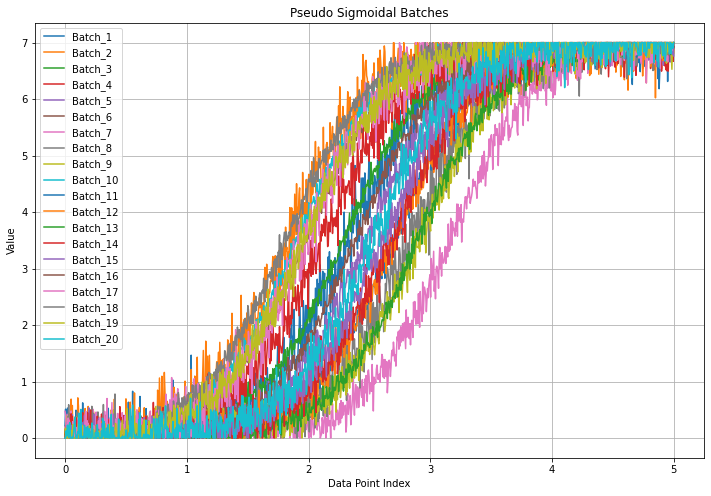

In [17]:
plot_batches_long(df_long)

In [18]:
save_batches_to_csv(df_long, df_metadata, data_filename='pseudo_sigmoid_batches_long.csv',
                        metadata_filename='pseudo_sigmoid_batches_metadata.csv')

Data saved to 'pseudo_sigmoid_batches_long.csv' and metadata saved to 'pseudo_sigmoid_batches_metadata.csv'.
